# PyNeuro
## Модель машинного обучения  - НЕЙРОННАЯ СЕТЬ

In [1]:
from copy import deepcopy
import numpy as np
from numpy import random as rd
import matplotlib.pyplot as plt

In [2]:
class NeuralNetwork(object):
    
    """
    Класс Нейронная сеть
    Обучение сети проходит методом обратного распространения ошибки
    layers - объект типа list: например, layers = [4, 20, 10, 5, 1]
             4 нейрона на слое входных данных (input layers);
             3 скрытых слоя сети NN (hidden layers), содержащих 20, 10 и 5 нейронов, соотвественно;
             1 нейрон в выходном слое (output layers).
    """
    
    def __init__(self, layers, weights=None):
        self.layers = layers
        self.weights = weights
        self.activations_value = None
        self.summary_arg = None
        self.n_layers = len(layers)
    
    def __repr__(self):
        return f"NeuralNetwork:\n - input layer: {self.layers[0]} neurons;\n - output layer: {self.layers[-1]} neurons;\n - hidden layers: {len(self.layers[1:-1])}"
    
    def function_activation(self, arg):
        """
        Ф-ция активации - бинарная сигмоидальная функция с областью значений (0, 1)
        """
        fx = 1 / (1 + np.exp(-arg))
        if fx == 1:
            return 1 - 1e-9
        elif fx == 0:
            return 0 + 1e-9
        else:
            return fx
    
    def derivative_activation(self, arg):
        return (1 / (1 + np.exp(-arg))) * (1 - (1 / (1 + np.exp(-arg))))
    
    def create(self):
        """
        Ф-ция инициилизации нейронной сети. С помощью генератора списка создает матрицы 
        весов связей weights между нейронами каждого слоя со случайными числами от -1 до 1.
        !ПРИМЕЧАНИЕ!: начальная матрица весов W[0] = 0.
        """
        self.weights = [np.mat(rd.uniform(-1, 1, (self.layers[i], 1+self.layers[i-1])))
                     if i!=0 else 0 for i in range(self.n_layers)]
        
    def run(self, input_data):
        """
        Ф-ция вычисления матрицы выходных сигналов сети. 
        input_data - входные данные (может быть несколько сразу)
        !ПРИМЕЧАНИЕ!: Значения активационной функции для входного слоя равны самим значениям
        """
        count_sample = len(input_data)
        self.activations_value = [deepcopy(input_data)]
        self.summary_arg = [0]   
        fa = np.vectorize(self.function_activation)
        
        for i in range(1, self.n_layers):
            self.activations_value[i-1] = np.c_[np.ones(count_sample), self.activations_value[i-1]]
            self.summary_arg.append(self.activations_value[i-1] * self.weights[i].T)
            self.activations_value.append(fa(self.summary_arg[i]))
            
        out_signal = self.activations_value[-1]
        return out_signal
            
    def backpropagation(self, X, Y_expect, lambd):
        """
        Метод обратного распространения ошибки
        X - входные значения
        Y_expect - ожидаемые выходные значения сети 
        """
        count_layers = self.n_layers
        count_sample = len(X)
        delta_W = [0] * count_layers
        Y_expect = np.matrix(Y_expect)
        Y = deepcopy(self.run(X))
        W = deepcopy(self.weights)
        Z = deepcopy(self.summary_arg)
        A = deepcopy(self.activations_value)
        foo_der = np.vectorize(self.derivative_activation)
        
        for n in range(0, count_sample):
            delta = [0] * (count_layers + 1)
            delta[-1] = (Y[n] - Y_expect[n]).T
            for i in range(count_layers - 1, 0, -1):
                if i > 1:
                    z = Z[i-1][n]
                    z = np.c_[[[1]], z]
                    delta[i] = np.multiply(W[i].T * delta[i + 1], foo_der(z).T)
                    delta[i] = delta[i][1:]
                delta_W[i] += delta[i + 1] * A[i - 1][n]

        for i in range(1, len(delta_W)):
            delta_W[i] = delta_W[i] / count_layers
            delta_W[i][:, 1:] = delta_W[i][:, 1:] + W[i][:, 1:] * (lambd / count_layers)
            
        return delta_W
    
    def get_error(self, X, Y, lambd):
        """
        Ф-ция вычисления ошибки выходного сигнала нейронной сети с регуляризацией
        lambd - коэффициент регуляризации
        X - входные данные
        Y - выходные значения 
        """
        count_sample = len(X)
        Y = np.matrix(deepcopy(Y))
        W = deepcopy(self.weights)
        H = self.run(X)
        
        cost = (-1 * Y.T * np.log(H) - (1 - Y.T) * np.log(1 - H)).sum(axis=0).sum(axis=1)
        regul = 0
        
        for i in range(1, len(W)):
            W[i] = np.delete(W[i], 0, axis=1)
            W[i] = np.power(W[i], 2)
            regul += W[i].sum(axis=0).sum(axis=1)
            
        return cost / count_sample + (lambd / (2 * count_sample)) * regul

    def training(self, xTrain, yTrain, xTest, yTest, alpha=0.2, lambd=0.3, maxiter=1000, callback=False):
        """
        Ф-ция обучения нейронной сети - подбирает матрицу весов связей на основе обучающей выборки
        alpha - отвечает за скорость обучения (насколько сильно изменяется матрица весов в каждой итерации)
        """
        eps, mi = 1, 0
        res_back = []
        
        while eps > 0 and mi < maxiter:
            eps = self.get_error(xTrain, yTrain, lambd)
            eps_test = self.get_error(xTest, yTest, lambd)
            delta = self.backpropagation(xTrain, yTrain, lambd)
            self.weights = [self.weights[i] - alpha * delta[i] for i in range(len(self.weights))]
            mi += 1
            if callback is True:
                res_back.append(self.run(xTest))
                
        print(f'iter: {mi}, error train: {eps[0, 0]}, error test: {eps_test[0, 0]}')
        print(f'X_test:\n{self.run(xTest)}')
        return res_back

## Пример обучения нейронной сети

In [168]:
layers = [4, 50, 1]

In [169]:
# Создание объекта класса Нейронная сеть
NN = NeuralNetwork(layers)
NN

NeuralNetwork:
 - input layer: 4 neurons;
 - output layer: 1 neurons;
 - hidden layers: 1

In [170]:
# Создание нейронной сети (инициилизация случаных весовых коэф-ов связей)
NN.create()

In [171]:
# Обучающая выборка: если последовательность возрастающая то 1, иначе - 0
X_train = [[1, 2, 3, 4],
          [5, 6, 7, 8],
          [9, 10, 11, 12],
          [1, 3, 5, 7],
          [2, 4, 6, 8],
          [1.1, 1.2, 1.3, 1.4],
          [1.5, 1.6, 1.7, 1.8],
          [1.9, 2.0, 2.1, 2.2],
          [2.3, 2.4, 2.5, 2.6],
          [2.7, 2.8, 2.9, 3.0],
          [3.15, 3.33, 3.54, 3.88],
          [4.5, 5.5, 6.5, 7.5],
          [1.9, 2.9, 3.9, 4.9],
          [5.55, 6.66, 7.77, 8.88],
          [4.6, 5.8, 6.0, 8.1],
          [4, 3, 2, 1],
          [8, 7, 6, 5],
          [12, 11, 10, 9],
          [7, 5, 3, 1],
          [8, 6, 4, 2],
          [1.45, 1.34, 1.23, 1.12],
          [1.89, 1.78, 1.66, 1.51],
          [2.24, 2.18, 2.05, 1.9],
          [2.64, 2.50, 2.48, 2.37],
          [3.1, 2.95, 2.82, 2.71],
          [3.94, 3.75, 3.59, 3.45],
          [8.59, 7.58, 6.57, 5.56],
          [4.98, 3.9, 2.98, 1.9],
          [8.86, 7.76, 6.66, 5.56],
          [9.5, 5.67, 4.7, 1.46],]
Y_train = [[1], [1], [1], [1], [1], [1], [1], [1], [1], [1], [1], [1], [1], [1], [1],
          [0], [0], [0], [0], [0], [0], [0], [0], [0], [0], [0], [0], [0], [0], [0]]

In [172]:
X_test= [[1.25, 2.25, 3.25, 4.25],
         [2.28, 3.38, 4.38, 5.38],
         [5.55,6.66, 7.77, 8.88],
         [1.11, 2.22, 3.33, 4.44],
         [3.7, 6.8, 7.9, 8.0],
         [6.94, 5.81, 4.38, 1.2],
         [6.0, 5.0, 4.4, 3.5],
         [7.26, 6.69, 4.3, 4.29],
         [2.25, 2.20, 2.15, 2.10],
         [9, 8, 7, 6]]
Y_test = [[1], [1], [1], [1], [1],
          [0], [0], [0], [0], [0]]

In [173]:
# Обучение созданной сети
%time res = NN.training(X_train, Y_train, X_test, Y_test, maxiter=100, callback=True)

iter: 100, error train: 0.3868615952125125, error test: 0.6349862759189993
X_test:
[[0.9564553 ]
 [0.94866813]
 [0.89918981]
 [0.96630078]
 [0.96120412]
 [0.0063487 ]
 [0.01830394]
 [0.01488307]
 [0.14261797]
 [0.02221473]]
Wall time: 9.15 s


In [174]:
# Матрица весов после обучения нейронной сети
Weights = NN.weights
Weights

[0.0,
 matrix([[-0.80189513, -0.64479605, -0.2405505 ,  0.24472185,  0.53542415],
         [-0.43580671, -0.83424974, -0.15458279,  0.23889048,  0.56368852],
         [ 0.33073902, -0.25120732, -0.16149999, -0.10821561, -0.11410549],
         [-0.30905506, -0.0283404 , -0.13549194, -0.05682476, -0.1730135 ],
         [-0.45766326, -0.9800193 , -0.39535911,  0.25968576,  0.8909188 ],
         [-0.39170762, -0.41565936, -0.23405846,  0.04723204,  0.26698651],
         [ 0.29075299,  0.00492389, -0.02641579, -0.04936723, -0.30454118],
         [ 0.47280477, -0.03841339, -0.0600397 , -0.29790534, -0.65447759],
         [-0.43249238, -0.26958138, -0.17625241, -0.04348227,  0.08824489],
         [-0.4626261 , -0.33955572, -0.06536175, -0.05353496,  0.0695657 ],
         [-0.01743381, -0.14679307, -0.26678122, -0.12973964,  0.01603483],
         [ 0.02997551,  1.13405799,  0.36199033, -0.33564286, -0.99085808],
         [-0.21239383, -0.02747479, -0.21567528, -0.18633057, -0.03352122],
      

In [175]:
# Проверка (экзамен) нейронной сети
NN.run([[1.25, 2.2, 3.15, 4.1]])

matrix([[0.95107301]])

In [176]:
arr_history_train_1 = [i[1,0]  for i in res]  # пример с увеличивающейся последовательностью [2.28, 3.38, 4.38, 5.38]
arr_history_train_0 = [i[-1,0] for i in res]  # пример с уменьшающейся последовательностью [9, 8, 7, 6]

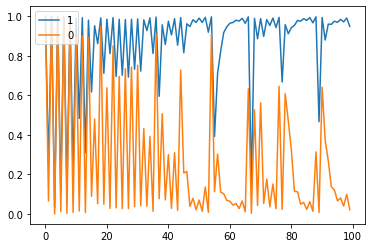

In [177]:
plt.figure()
plt.plot(arr_history_train_1, label='1')
plt.plot(arr_history_train_0, label='0')
plt.legend(loc=2)
plt.show()